# RSS

In [1]:
import feedparser
from datetime import datetime

DATA_PATH='/home/bkadmin/datasets/spatialedge-hackathon-H1/v1/' 
FROM_DATE='20200101'
TO_DATE='20221231'
SYMBOL = 'EURUSD'
TIMEFRAME = 'H1'

### Pull feed from google News

In [86]:
feed = feedparser.parse("https://news.google.com/rss/search?q=central+bank+US+EU+site%3Abloomberg.com+when%3A1d&hl=en-ZA&gl=ZA&ceid=ZA%3Aen")

#feed = feedparser.parse("https://news.google.com/rss/topics/CAAqJggKIiBDQkFTRWdvSUwyMHZNRGx6TVdZU0FtVnVHZ0pWVXlnQVAB/sections/CAQiSENCQVNNQW9JTDIwdk1EbHpNV1lTQW1WdUdnSlZVeUlQQ0FRYUN3b0pMMjB2TUdkbWNITXpLZ3NTQ1M5dEx6Qm5abkJ6TXlnQSoqCAAqJggKIiBDQkFTRWdvSUwyMHZNRGx6TVdZU0FtVnVHZ0pWVXlnQVABUAE?hl=en-US&gl=US&ceid=US%3Aen")

#feed = feedparser.parse("https://news.google.com/rss/search?q=EU+Europe+when%3A1y+-War+-Cut+-Cuts+-Low&hl=en-ZA&gl=ZA&ceid=ZA%3Aen")

print('Number of RSS posts :', len(feed.entries))

Number of RSS posts : 100


### Exstract Titles and publish dates

In [88]:
titles = []
dates = []

for post in feed.entries:
    title = post.title
    date = post.published
    titles.append(title.replace(' - Bloomberg', ''))
    dates.append(datetime.strptime(date, '%a, %d %b %Y %X %Z').date())

### Exstract tags from titles

In [89]:
if SYMBOL == 'EURUSD':
    search = ['US','U.S.' 'EU', 'Europe']
else:
    search = []

tags_in_title = []
for title in titles:
    tags = []
    for tag in search:
        if tag.lower() in title.lower(): tags+=[tag]
    tags_in_title += [tags]

print(tags_in_title)

[['Europe'], ['Europe'], [], ['US'], [], ['US'], [], ['US'], [], [], [], [], [], [], [], [], [], [], [], [], ['US'], [], ['US'], ['US'], ['US'], [], ['US'], [], [], [], [], [], ['US'], [], ['US'], ['US'], [], [], [], ['US'], [], [], ['US'], [], [], [], ['Europe'], [], [], ['US'], ['US'], [], [], ['US', 'Europe'], ['US'], [], [], ['US'], [], ['US'], [], ['US'], [], [], ['US'], [], [], ['US'], ['US'], ['US'], [], [], [], [], ['US'], ['US'], [], [], [], ['US'], [], [], [], [], [], [], ['US'], [], [], [], ['US'], [], [], [], [], [], [], [], [], []]


### Create Dataframe

In [90]:
import pandas as pd

df = pd.DataFrame({'Title': titles,'Tags': tags_in_title,'Date': pd.to_datetime(dates)})

df.info()
print(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Title   100 non-null    object        
 1   Tags    100 non-null    object        
 2   Date    100 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 2.5+ KB
                                                Title      Tags       Date
0   Europe Inflation: Governments Aren't Helping E...  [Europe] 2023-10-06
1   BYD to Stick to Europe Growth Plans Despite Su...  [Europe] 2023-10-07
2   EU Migration: Macron, Scholz, Orban, Sunak Fig...        [] 2023-10-06
3   Larry Summers Says Fed's Rate Hikes May Not Be...      [US] 2023-10-06
4   Azeri Plan to Double Gas Exports to EU at Risk...        [] 2023-10-06
..                                                ...       ...        ...
95  Panama Bonds Near 14-Year Low on Threat of Bec...        [] 2023-10-06
96  CEO Codelco si

## Model

#### Import training dataset

In [7]:
DATASETS = '~/datasets/sentiment_economy_news/'

train = pd.read_parquet(DATASETS + 'train.parquet', engine='pyarrow')
test  = pd.read_parquet(DATASETS + 'test.parquet', engine='pyarrow')

print(train.tail())
print(train.info())

print(test.tail())
print(test.info())

                                                   text    labels  \
2995  'Derogatory' Files Ended Service Of 383 U. S. ...  negative   
2996  Treasury Securities Are Becalmed: Investors Aw...  negative   
2997  SENATE TEST WON BY RIGHTS FORCES: PANEL VOTES ...  negative   
2998  FARMERS PUNISHED IN WETBACK' DRIVE: SOME PERMI...  negative   
2999  EXECUTIVE HIRING EXPECTED TO RISE: STUDY SHOWS...  positive   

          articleid relevance positivity  split positivity_rounded   idx  
2995  nyt_113139986       yes        2.0  train                2.0  2995  
2996  nyt_108972463       yes        4.0  train                4.0  2996  
2997  nyt_119217245       yes        4.0  train                4.0  2997  
2998  nyt_112200942       yes        4.0  train                4.0  2998  
2999  nyt_119481498       yes        6.5  train                6.0  2999  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column              Non-

#### Create a classifier model

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

X_train = train['text']
X_test = test['text']

Y_train = pd.Categorical(train['labels'])
Y_test = pd.Categorical(test['labels'])
labels = Y_train.categories

vectorizer = CountVectorizer()

X_train_tokens = vectorizer.fit_transform(train["text"])

transformer = TfidfTransformer()

X_train_tf = transformer.fit_transform(X_train_tokens)

title_clf = GaussianNB().fit(X_train_tf.toarray(), Y_train)

#title_clf = Pipeline([
#    ('vect', CountVectorizer()),
#    ('tfidf', TfidfTransformer()),
#    ('clf', GaussianNB()),
#])

#### Train model

In [63]:


title_clf.fit(X_train, Y_train)

ValueError: could not convert string to float: 'Fed Finds Slow Pace Of Growth: Floods and Drought Fail to Halt Recovery Economic Activity Still Expanding Slowly. WASHINGTON, Aug. 4 — Neither flood nor rain nor searing drought is choking off the nation\'s modest economic recovery, even though they have been devastating to the Midwest and the South.</br></br>The 12 Federal Reserve Banks reported today that economic activity in most districts, including the Midwest, continued to expand "slowly to moderately” in June and the first half of July.</br></br>"The effects of flooding were said to be highly concentrated and were not seen to threaten overall economic expansion,” the Federal Reserve said in its latest survey of regional economic conditions, a report known as the beige book.</br></br>The Federal Reserve’s latest appraisal of economic conditions was based on surveys of farmers, bankers and business executives conducted before July 27. The Federal Reserve Banks assess economic conditions and price trends before the Fed’s monetary policy meetings, which are held roughly every six weeks. The next meeting of the Federal Open Market Committee, which decides whether to raise or lower short-term interest rates, is scheduled for Aug. 16 and 17.</br></br>The Federal Reserve’s chairman, Alan Greenspan, has been watching for signs that prices are starting to rise faster as the economy keeps growing, which could lead the Fed id raise rates to check inflation. But the report today found that price pressures were mixed.'

#### Evaluate Model

In [66]:

from sklearn.metrics import classification_report

X_test_tokens = vectorizer.transform(test['text'])
X_test_tf = transformer.transform(X_test_tokens)

predicted = title_clf.predict(X_test_tf.toarray())

print(classification_report(Y_test, predicted, target_names=labels))

              precision    recall  f1-score   support

    negative       0.62      0.78      0.69       241
    positive       0.34      0.19      0.24       141

    accuracy                           0.56       382
   macro avg       0.48      0.49      0.47       382
weighted avg       0.52      0.56      0.53       382



#### Plot a bar chart on predicted labels for testing data

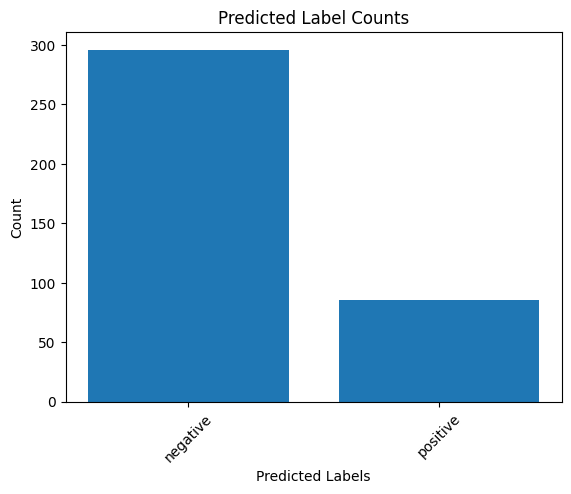

In [27]:
import matplotlib.pyplot as plt 
from collections import Counter

label_counts = Counter(predicted)

# Extract labels and counts as separate lists
labels = list(label_counts.keys())
counts = list(label_counts.values())

# Create a bar chart
plt.bar(labels, counts)
plt.xlabel('Predicted Labels')
plt.ylabel('Count')
plt.title('Predicted Label Counts')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

## Evaluate model on aggregated news sources

['positive' 'negative' 'negative' 'positive' 'positive' 'positive'
 'positive' 'positive' 'negative' 'positive' 'positive' 'negative'
 'positive' 'positive' 'negative' 'positive' 'positive' 'negative'
 'negative' 'positive' 'positive' 'negative' 'positive' 'positive'
 'positive' 'negative' 'positive' 'positive' 'positive' 'positive'
 'negative' 'positive' 'negative' 'negative' 'negative' 'positive'
 'positive' 'negative' 'positive' 'positive' 'positive' 'positive'
 'positive' 'positive' 'negative' 'positive' 'negative' 'positive'
 'positive' 'negative' 'positive' 'positive' 'positive' 'negative'
 'positive' 'positive' 'negative' 'negative' 'positive' 'positive'
 'positive' 'positive' 'positive' 'positive' 'negative' 'positive'
 'negative' 'positive' 'positive' 'positive' 'positive' 'negative'
 'positive' 'positive' 'negative' 'positive' 'negative' 'positive'
 'negative' 'positive' 'negative' 'positive' 'negative' 'positive'
 'negative' 'negative' 'positive' 'positive' 'positive' 'posit

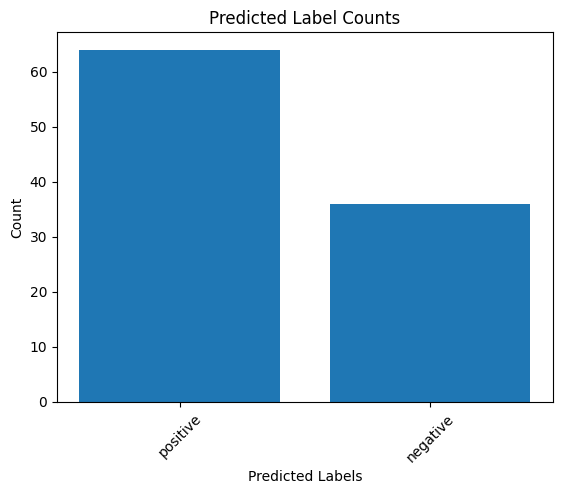

In [91]:
X_titles = df['Title']

X_titles_tokens = vectorizer.transform(X_titles)
X_titles_tf = transformer.transform(X_titles_tokens)

Y_result = title_clf.predict(X_titles_tf.toarray())

#print(classification_report(Y_test, Y_result, target_names=labeX_test_tfls))

print(Y_result)

for i in range(20):
    print(df.Title[i])

label_counts = Counter(Y_result)

# Extract labels and counts as separate lists
labels = list(label_counts.keys())
counts = list(label_counts.values())

# Create a bar chart
plt.bar(labels, counts)
plt.xlabel('Predicted Labels')
plt.ylabel('Count')
plt.title('Predicted Label Counts')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()